<a href="https://colab.research.google.com/github/annvix/Accents_LSTM-/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Клонирование проекта с GitHub
Подключение библиотек

In [1]:
!git clone https://github.com/annvix/Accents_LSTM-.git

fatal: destination path 'Accents_LSTM-' already exists and is not an empty directory.


In [0]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding

from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import sequence

from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random


# Загрузка и предобработка данных

Добавляем алфавит для кодирования букв

In [0]:
alphabet =   {'а' : 1, 'б' : 2, 'в' : 3, 'г' : 4, 'д' : 5, 'е' : 6, 'ё' : 7, 'ж' : 8, 'з' : 9,
             'и' : 10, 'й' : 11, 'к' : 12, 'л' : 13, 'м' : 14, 'н' : 15, 'о' : 16, 'п' : 17, 'р' : 18,
             'с' : 19, 'т' : 20, 'у' : 21, 'ф' : 22, 'х' : 23, 'ц' : 24, 'ч' : 25, 'ш' : 26, 'щ' : 27,
             'ъ' : 28, 'ы' : 29, 'ь' : 30, 'э' : 31, 'ю' : 32, 'я' : 33}

N = 10 #Количество слов для вывода

In [4]:
with open('Accents_LSTM-/Data.csv', 'r') as f:
    all_accents = f.readlines()
data_len = len(all_accents)

print('Всего слов:', data_len)
max_len = len(max(all_accents, key=len)) //2 - 1
print('Максимальная длина слова:', max_len)
print('Слово:', max(all_accents, key=len))
number_of_classes = max_len + 1

Всего слов: 1679079
Максимальная длина слова: 29
Слово: административнодисциплинарный,административнодисципл'инарный



Группировка слов по первым буквам

In [5]:
word_groups = []
group  = []
group.append(all_accents[0])

for i in range(1, data_len):
    if group[0][:4] == all_accents[i][:4]:
        group.append(all_accents[i])
    else:
        word_groups.append(group)
        group  = []
        group.append(all_accents[i])
print('Количество групп: ', len(word_groups))
random.shuffle(word_groups)

Количество групп:  42117


In [6]:
print('Группы слов:')
for i in range (N):
  print(word_groups[i])

Группы слов:
["уезд,у'езд\n", "уезда,у'езда\n", "уездам,у'ездам\n", "уездами,у'ездами\n", "уездах,у'ездах\n", "уезде,у'езде\n", "уездивший,у'ездивший\n", "уездившийся,у'ездившийся\n", "уездить,у'ездить\n", "уездиться,у'ездиться\n", "уездная,у'ездная\n", "уездно,у'ездно\n", "уездного,у'ездного\n", "уездное,у'ездное\n", "уездной,у'ездной\n", "уездном,у'ездном\n", "уездному,у'ездному\n", "уездною,у'ездною\n", "уездную,у'ездную\n", "уездные,у'ездные\n", "уездный,у'ездный\n", "уездным,у'ездным\n", "уездными,у'ездными\n", "уездных,у'ездных\n", "уездов,у'ездов\n", "уездом,у'ездом\n", "уезду,у'езду\n", "уезды,у'езды\n"]
["дакша,д'акша\n"]
["вайтань,вайт'ань\n", "вайтаскоп,в'айтаскоп\n", "вайтекунас,вайтек'унас\n", "вайткус,в'айткус\n", "вайтнау,в'айтнау\n"]
["эрэб,эр'эб\n"]
["фру,фр'у\n"]
["штехбарт,шт'ехбарт\n"]
["энсаррия,энсарри'я\n"]
["илен,'илен\n"]
["слойчатый,сл'ойчатый\n"]
["алая,'алая\n"]


Разделим данные на тренировочные, валидационные и тестовые

In [0]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

def train_test_val_words(words):
    return (words[:int(len(words)*train_frac)], 
words[int(len(words)*train_frac) : (int(len(words)*train_frac) + int(len(words)*val_frac))], 
words[(int(len(words)*train_frac) + int(len(words)*val_frac)):])
    

for_train, for_val, for_test = train_test_val_words(word_groups)

In [0]:
def words_to_num(my_words):
  words, accents = [], []
  for i in range (len(my_words)):
      str = my_words[i].replace('\n', '').split(',')
      words.append(str[0])
      accents.append(str[1])

  words_int = np.zeros((len(my_words), number_of_classes), dtype=int)
  accents_int = np.zeros((len(my_words),number_of_classes), dtype=int)
  
  for i in range(len(words)):
    for j in range(len(words[i])):
        words_int[i][j]= alphabet[words[i][j]]
        
    acc = accents[i].find("'")
    if (acc != -1):
        accents_int[i][acc] = 1
        if accents[i][acc + 1:].find("'") != -1:
          print('В слове два ударения', words[i])
    else:
        accents_int[i][number_of_classes - 1] = 1
        print('Нет ударения: ', words[i])
  return words_int, accents_int

In [36]:
train_x, train_y= [], []
for i in range(len(for_train)):
  w, a = words_to_num(for_train[i])
  for j in range(len(for_train[i])):
    train_x.append(w[j])
    train_y.append(a[j])
  
val_x, val_y= [], []
for i in range(len(for_val)):
  w, a = words_to_num(for_val[i])
  for j in range(len(for_val[i])):
    val_x.append(w[j])
    val_y.append(a[j])

test_x, test_y= [], []
for i in range(len(for_test)):
  w, a = words_to_num(for_test[i])
  for j in range(len(for_test[i])):
    test_x.append(w[j])
    test_y.append(a[j])


Нет ударения:  гм
Нет ударения:  брр
Нет ударения:  тсс
Нет ударения:  к
Нет ударения:  ж
Нет ударения:  с
Нет ударения:  хм
Нет ударения:  б
Нет ударения:  в
Нет ударения:  мм
Нет ударения:  кш
Нет ударения:  ль


In [0]:
test_x = np.array(test_x) 
train_x = np.array(train_x) 
val_x = np.array(val_x) 

test_y = np.array(test_y) 
train_y = np.array(train_y) 
val_y = np.array(val_y) 

In [48]:
print("\t\t\t Размеры:")
print("Train set: \t\t{}".format(test_x.shape), 
      "\nValidation set: \t{}".format(train_x.shape),
      "\nTest set: \t\t{}".format(val_x.shape))

			 Размеры:
Train set: 		(161456, 30) 
Validation set: 	(1332087, 30) 
Test set: 		(185535, 30)


# Моделирование нейронной сети
Используется LSTM-сеть

In [49]:
max_features = len(alphabet) + 1
max_features

34

In [50]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = number_of_classes, input_length=number_of_classes))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 30)            1020      
_________________________________________________________________
lstm (LSTM)                  (None, 128)               81408     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                7710      
Total params: 123,162
Trainable params: 123,162
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
batch_size = 256
epochs = 3

print(u'Тренируем модель...')
history = model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y))

Тренируем модель...
Epoch 1/3
5204/5204 [==============================] - 1290s 248ms/step - loss: 1.5233 - accuracy: 0.4239 - val_loss: 0.8775 - val_accuracy: 0.6914
Epoch 2/3
5204/5204 [==============================] - 1291s 248ms/step - loss: 0.8108 - accuracy: 0.7042 - val_loss: 0.6778 - val_accuracy: 0.7463
Epoch 3/3
5204/5204 [==============================] - 1272s 244ms/step - loss: 0.6776 - accuracy: 0.7422 - val_loss: 0.6019 - val_accuracy: 0.7671


Построим графики для точности и функции стоимости относительно эпох

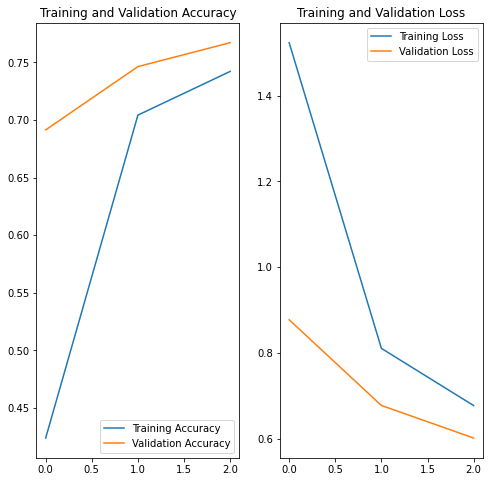

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Сохраним предобученную сеть

In [0]:
model.save('Accents_LSTM-/LSTM_model.h5')

Сохраним датасет и предобученную сеть на компьютер

In [0]:
#files.download('Accents_LSTM-/Data.csv')
files.download('Accents_LSTM-/LSTM_model.h5')

# Тесты на обученной модели

In [0]:
model = load_model('Accents_LSTM-/model.h5')

In [0]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy'),
                  metrics=['accuracy'])

Предскажем позицию ударения для тестовых данных

In [57]:
acc_pred = model.predict(test_x)

test_accur = 0
for i in range(len(acc_pred)):
    if acc_pred[i].argmax() == test_y[i].argmax():
        test_accur = test_accur + 1
test_accur = test_accur/len(acc_pred)

In [58]:
print('Точность на тестовой выборке: ',test_accur)

Точность на тестовой выборке:  0.8499281538004162


Метод для возвращения ключа по значению

In [0]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

Визуализация предсказанных ударений и их сравнение с ответами

In [65]:
for i in range(N):
    slovo = ''
    for j in range(len(test_x[i*100])):
        if test_x[i*100][j] != 0:
            slovo = slovo + get_key(alphabet, test_x[i*100][j])
        else:
            break
    template = slovo[:test_y[i*100].argmax() + 1] + '\'' + slovo[test_y[i*100].argmax() + 1:]
    nn_sample = slovo[:acc_pred[i*100].argmax() + 1] + '\'' + slovo[acc_pred[i*100].argmax() + 1:]
    
    if (acc_pred[i*100].argmax() != test_y[i*100].argmax()):
      print('Эталон   : ' , template)
      print('Результат: ' , nn_sample)
    else:
      print('Результат: ' , nn_sample)
    print()

Результат:  люза'к

Эталон   :  клыка'стыми
Результат:  клы'кастыми

Эталон   :  зева'нный
Результат:  зе'ванный

Эталон   :  вещево'
Результат:  ве'щево

Результат:  уложе'ния

Результат:  дроги'чинами

Результат:  шнурова'вшую

Результат:  шнуру'ется

Результат:  сра'внивайся

Результат:  сравни'мую

